Använd maskininlärning för att modellera MNIST datan. Du skall utvärdera minst två olika modeller i 
ditt arbete och göra ett komplett ML-flöde, från början där du laddar in data till slut där du 
utvärderar den bäst valda modellen på din test data. Hur du laddar ned MNIST datan kan du se här. 

In [77]:
#importerar bibliotekerna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
import joblib


EDA

In [78]:
# Ladda MNIST-datan
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

print (mnist.DESCR)


# Data och labels
X = mnist["data"]
y = mnist["target"].astype(np.uint8)


**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Preparing Data

In [79]:
# Split the data: 80% for training and 20% for testing
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=10000, random_state=42)

# Kolla storleken på datasetet
print(f"Träningsdata: {X_train.shape}")
print(f"Valideringsdata: {X_val.shape}")
print(f"Testdata: {X_test.shape}")


Träningsdata: (60000, 784)
Valideringsdata: (10000, 784)
Testdata: (14000, 784)


Image Data Normalization:

In [80]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

Selecting and displaying two random images

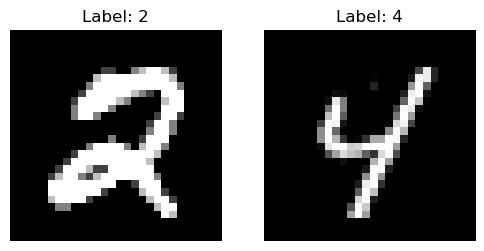

In [81]:

# Select two random images from the dataset
image1 = X_train[0].reshape(28, 28)  # First image
image2 = X_train[1].reshape(28, 28)  # Second image

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Display the first image
axes[0].imshow(image1, cmap="gray")
axes[0].set_title(f"Label: {y_train[0]}")
axes[0].axis("off")

# Display the second image
axes[1].imshow(image2, cmap="gray")
axes[1].set_title(f"Label: {y_train[1]}")
axes[1].axis("off")

# Show the images
plt.show()

 Selecting the 10th image

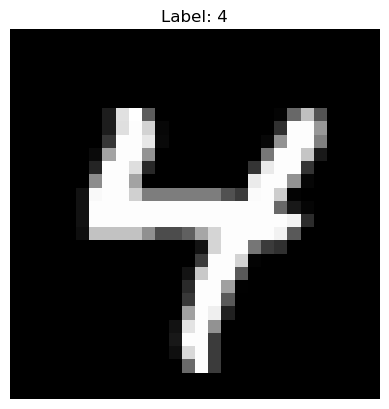

In [82]:
# Select the 10th image (index 9 since Python uses 0-based indexing)
image_10 = X_train[9].reshape(28, 28)

# Display the image
plt.imshow(image_10, cmap="gray")
plt.title(f"Label: {y_train[9]}")
plt.axis("off")  # Hide axes for better visualization
plt.show()

In [83]:
# Initiate the ExtraTreesClassifier with parallel processing
Model_Extra_trees = ExtraTreesClassifier(random_state=42, n_jobs=-1)

# Define optimized parameter grid
param_grid_Etc = {
    'n_estimators': [50],  # Fewer trees
    'max_depth': [10, None],  # Fewer values to test
}

# GridSearchCV with 2-fold cross-validation
grid_search_Etc = GridSearchCV(
    Model_Extra_trees, param_grid_Etc, cv=2, n_jobs=-1, verbose=2, scoring='accuracy'
)

# Fit the model to the smaller dataset
grid_search_Etc.fit(X_train, y_train)

#Make predictions
y_pred_Etc = grid_search_Etc.predict(X_test)


# Get best parameters and evaluate
best_Etc_clf = grid_search_Etc.best_estimator_
val_score_Etc = best_Etc_clf.score(X_val, y_val)
print("Best Parameters:", grid_search_Etc.best_params_)
print("Validation Accuracy:", val_score_Etc)




Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best Parameters: {'max_depth': None, 'n_estimators': 50}
Validation Accuracy: 0.9663


Classification report for the model's predictions

In [84]:
#print classification report for model
print(classification_report(y_test, y_pred_Etc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.96      0.98      0.97      1380
           3       0.96      0.97      0.96      1433
           4       0.97      0.98      0.97      1295
           5       0.98      0.97      0.97      1273
           6       0.98      0.99      0.99      1396
           7       0.98      0.98      0.98      1503
           8       0.97      0.95      0.96      1357
           9       0.97      0.96      0.96      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



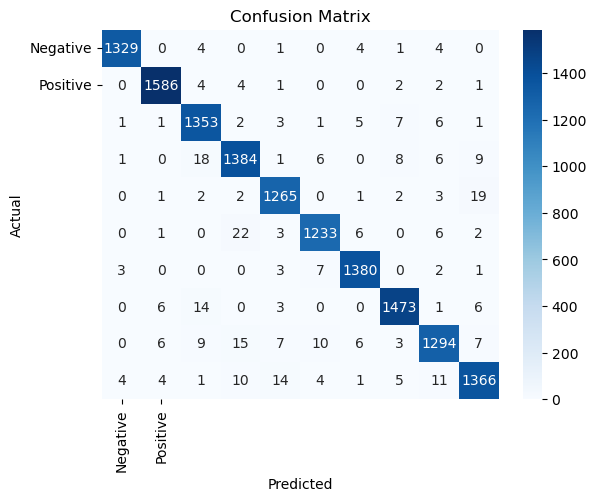

In [85]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_Etc)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RandomForestClassifier and accuracy score

In [86]:
# Initiate the RandomForestClassifier with parallel processing
random_forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Fit the model to the smaller dataset
random_forest_clf.fit(X_train, y_train)

#Make predictions
y_val_pred_rf =random_forest_clf.predict(X_val)

# Get best parameters and evaluate
Val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print(Val_accuracy_rf)


0.9674


Best Model

In [87]:
# Compare models
if Val_accuracy_rf  > val_score_Etc:
    print(f"Best model is Random Forest with accuracy: {Val_accuracy_rf :.4f}")
else:
    print(f"Best model is Extra Trees Classifier with accuracy: {val_score_Etc:.4f}")

Best model is Random Forest with accuracy: 0.9674


As best model is  Random forestclassifier. So now i apply test on unseen data

In [88]:
#Test accuracy for ExtraTreesClassifier
accuracy_rf = accuracy_score(y_test, y_pred_Etc)
print(f"Test Accuracy: {accuracy_rf:.2f}")

Test Accuracy: 0.98


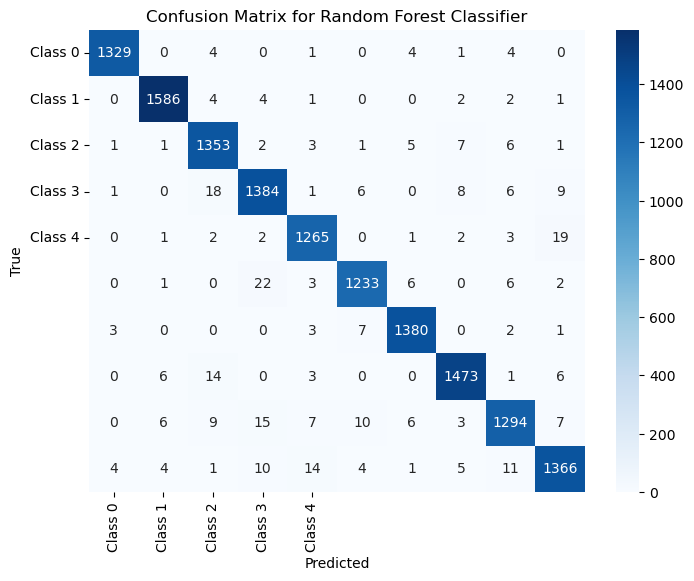

In [92]:
# Generate the confusion matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Classification report

In [89]:
#print classification report for model
print(classification_report(y_test, y_pred_Etc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.96      0.98      0.97      1380
           3       0.96      0.97      0.96      1433
           4       0.97      0.98      0.97      1295
           5       0.98      0.97      0.97      1273
           6       0.98      0.99      0.99      1396
           7       0.98      0.98      0.98      1503
           8       0.97      0.95      0.96      1357
           9       0.97      0.96      0.96      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [90]:
# Save the trained model
joblib.dump(random_forest_clf, 'randomforest.pkl')

['randomforest.pkl']